# Прогнозирование оттока клиентов оператора связи

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

__Описание услуг__

Оператор предоставляет два основных типа услуг:

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

Информация о договорах актуальна на 1 февраля 2020.

## Общий обзор данных

In [2]:
RANDOM_STATE = 140823
import pandas as pd #подключаем необходимые библиотеки
from matplotlib import pyplot as plt
import seaborn as sns
from phik import phik_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.dummy import DummyClassifier

In [ ]:
try:
    contracts = pd.read_csv('D:\datasets\contract_new.csv', sep = ',') 
except:
    contracts = pd.read_csv('/datasets/contract_new.csv', sep = ',')

In [ ]:
try:
    personal = pd.read_csv('D:\datasets\personal_new.csv', sep = ',') 
except:
    personal = pd.read_csv('/datasets/personal_new.csv', sep = ',')

In [ ]:
try:
    internet = pd.read_csv('D:\datasets\internet_new.csv', sep = ',') 
except:
    internet = pd.read_csv('/datasets/internet_new.csv', sep = ',')

In [ ]:
try:
    phone = pd.read_csv('D:\datasets\phone_new.csv', sep = ',') 
except:
    phone = pd.read_csv('/datasets/phone_new.csv', sep = ',')

Так как данные были переданы в 4 файлах, рассмотрим их по порядку

In [4]:
contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [5]:
contracts.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


На первый взгляд в исходных данных отсутствую пропуски, столбцы BeginDate и EndDate нужно привести к дате, TotalCharges к дроби, а Type, PaperlessBilling и PaymentMethod нужно будет перекодировать для проверки линейной модели. Также в таблице содержится целевой признак - столбец EndDate, где наличие даты означает, что пользователь перестал пользоваться услугами компании.

In [6]:
# изменим тип данных в столбце с ежемесячными тратами
contracts.TotalCharges = contracts.TotalCharges.replace(' ', float('nan'))
contracts.TotalCharges = contracts.TotalCharges.astype('float')

In [7]:
contracts.TotalCharges.isna().sum()

11

In [8]:
contracts.describe()

,MonthlyCharges,TotalCharges
count,7043.000000,7032.000000
mean,64.761692,2118.621822
std,30.090047,2112.736199
min,18.250000,19.050000
25%,35.500000,439.745000
50%,70.350000,1345.275000
75%,89.850000,3239.317500
max,118.750000,9221.380000


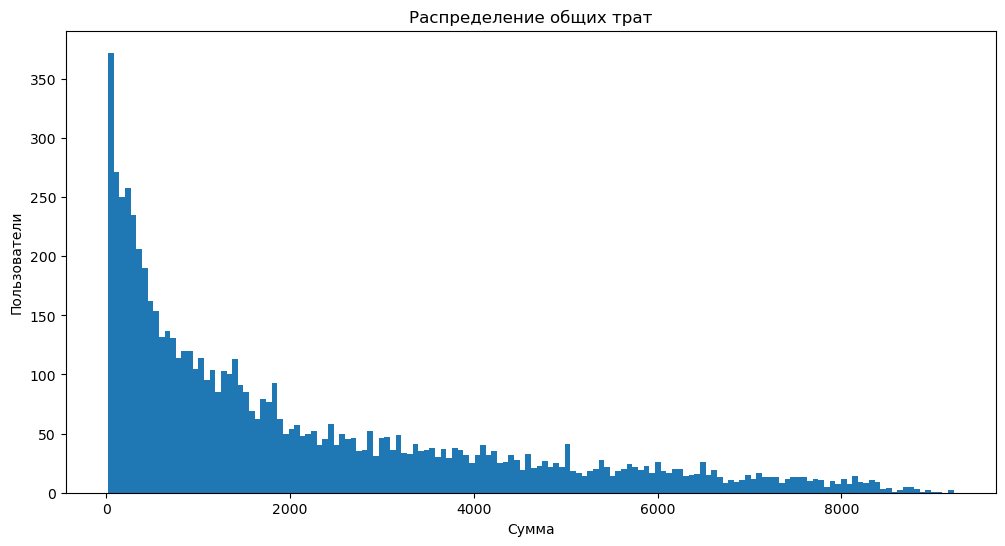

In [9]:
x = contracts.TotalCharges
plt.figure(figsize=(12, 6))
plt.hist(x, 150, histtype ='bar')
plt.title('Распределение общих трат')
plt.ylabel('Пользователи')
plt.xlabel('Сумма')
plt.show()

В столбце с общей суммой оказалось 11 пропусков. По графику распределения видно, что присутствует большое количество значений близких к нулю, количество пользователей падает по мере увеличения суммы трат за услуги.

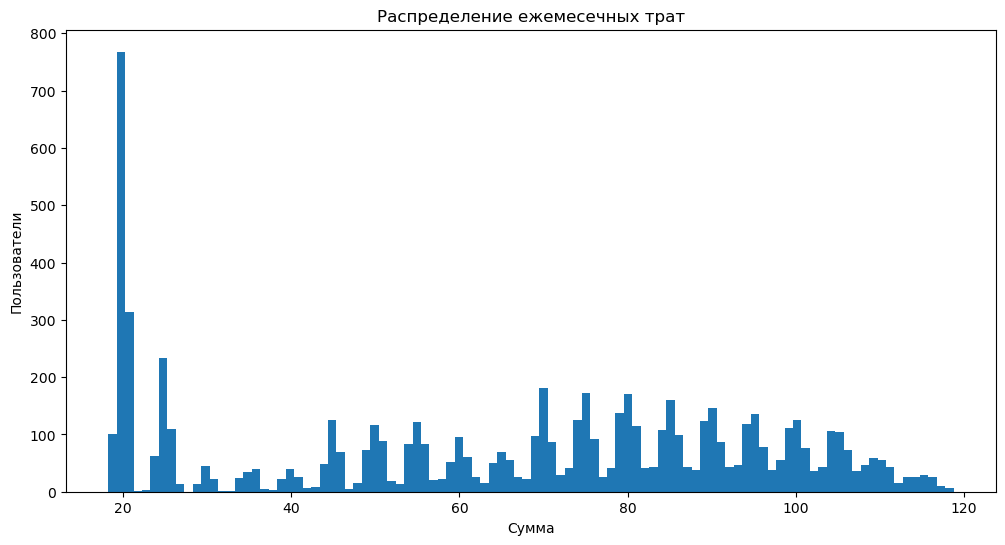

In [10]:
x = contracts.MonthlyCharges
plt.figure(figsize=(12, 6))
plt.hist(x, 100, histtype ='bar')
plt.title('Распределение ежемесечных трат')
plt.ylabel('Пользователи')
plt.xlabel('Сумма')
plt.show()

Месячные траты пользователей неравномерно распределены. Имеется много точек роста трат, что может показывать 'категории' пользователей по виду используемых услуг

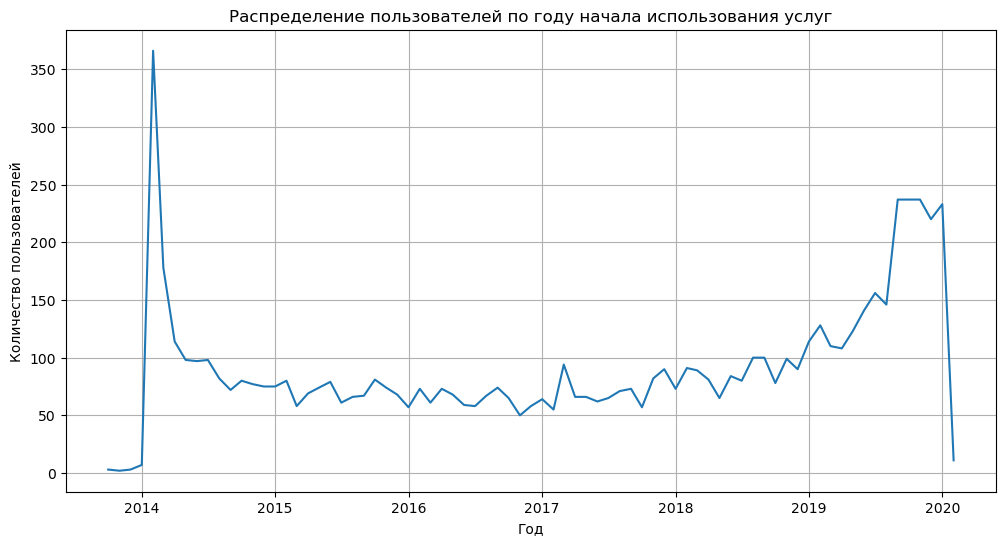

In [11]:
plt.figure(figsize=(12,6))
plt.plot(contracts.pivot_table(index=contracts.BeginDate.astype('datetime64[ns]'),
                        values='customerID', 
                        aggfunc='count'))
plt.xlabel('Год')
plt.ylabel('Количество пользователей')
plt.title('Распределение пользователей по году начала использования услуг')
plt.grid()

Пик новых пользователей компании наблюдался в начале 2014 года, также отмечается рост с 2019 по 2020 годы

In [12]:
active = contracts[contracts.EndDate == 'No']['EndDate'].count()
left = contracts.EndDate.count() - active
print(f'Кол-во активных пользователей - {active}')
print(f'Кол-во ушедших пользователей - {left}')

Кол-во активных пользователей - 5942
Кол-во ушедших пользователей - 1101


В данных наблюдается дисбаланс целевого признака

In [13]:
contracts.Type.value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

In [14]:
contracts[contracts.EndDate != 'No'].Type.value_counts()

Month-to-month    407
Two year          381
One year          313
Name: Type, dtype: int64

Больше половины пользователей используют ежемесячный тип подписки. Среди ушедших пользователей нет явного лидера

In [15]:
contracts.PaperlessBilling.value_counts()

Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

In [16]:
contracts[contracts.EndDate != 'No'].PaperlessBilling.value_counts()

Yes    721
No     380
Name: PaperlessBilling, dtype: int64

Большинство пользователей предпочитало электронный документооборот, такое же распределение и у ушедших пользователей

In [17]:
contracts.PaymentMethod.value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

In [18]:
contracts[contracts.EndDate != 'No'].PaymentMethod.value_counts()

Electronic check             350
Bank transfer (automatic)    317
Credit card (automatic)      317
Mailed check                 117
Name: PaymentMethod, dtype: int64

Большинство пользователей оплачивает услуги через электронный чек, среди ушедших пользователей меньше всего тех, кто оплачивал услуги по физическому чеку.

In [19]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [20]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Явных пропусков в таблице с персональными данными нет, столбцы содержат категориальные признаки с личной информацией пользователей

In [21]:
personal.gender.value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

Мужчин и женщин поровну

In [22]:
personal.SeniorCitizen.value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

Почти 17 процентов пользователей - пенсионеры

In [23]:
personal.Partner.value_counts()

No     3641
Yes    3402
Name: Partner, dtype: int64

Пользователей с супругом и без почти равное количество

In [24]:
personal.Dependents.value_counts()

No     4933
Yes    2110
Name: Dependents, dtype: int64

Пользователей без детей более чем в два раза меньше

In [25]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [26]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


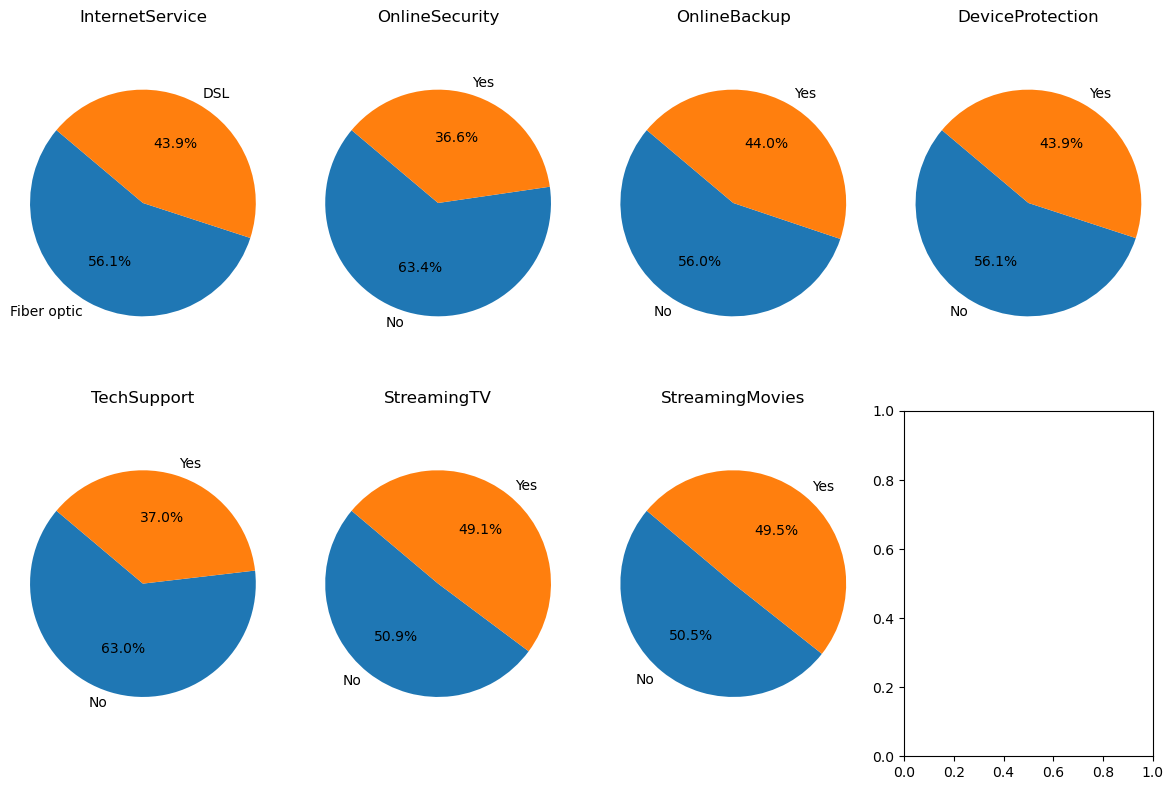

In [27]:
columns_to_plot = internet.columns[1:]
plots_per_row = 4
num_rows = 2
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(12, 4*num_rows))
axes = axes.ravel()

# Итерируем по столбцам и создаем круговые диаграммы
for i, column in enumerate(columns_to_plot):
    values = internet[column].value_counts()
    ax = axes[i]
    ax.pie(values, labels=values.index, autopct='%1.1f%%', startangle=140)
    ax.set_title(column)
    ax.axis('equal')  

plt.tight_layout()
plt.show()


Как видно из круговых диаграмм - в большинстве столбцов пользователей почти поровну. Меньше половины людей используют услуги антивируса и технической поддержки

In [28]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [29]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [30]:
phone.MultipleLines.value_counts()

No     3390
Yes    2971
Name: MultipleLines, dtype: int64

Пользователей с параллельными линиями во время звонка почти одинаковое количество

## План работы

1. Провести исследовательский анализ данных:
Посмотреть доступные данные, визуализировать их распределение и содержание, чтобы в дальнейшем выбрать нужные признаки и преобразовать типы данных;
2. Подготовка признаков:
Клиентские данные хранятся в 4 файлах - нужно объединить их в один датафрейм, на основе которого мы будем готовить признаки. Обработать пропуски, дубли и аномальные значения. Проверить мультиколлинеарность и отобрать признаки. Разделить выборку на обучающую и тестовую, масштабирование и балансировка;
3. Обучение и выбор модели: 
Обучить несколько моделей с целью выбора наиболее подходящей для задачи с помощью кросс-валидации, которая покажет наилучшую метрику;
4. Тестирование лучшей модели и вывод: 
Проверить лучшую модель на тестовой выборке и на адекватность, сделать вывод о результатах проделанной работы.

**Цель проекта - обучить модель, которая будет с высокой эффективностью определять потенциально уходящих клиентов, что позволит компании различными маркетинговыми инструментами удержать их и не уронить уровень прибыли**

## Подготовка признаков

### Подготовка данных

Для начала объединим данные из 4 таблиц и обработаем пропуски, которые возникнут из-за разницы в количестве записей в таблицах

In [31]:
# объединение таблиц contracts и internet
contracts_internet = pd.merge(contracts, internet, on='customerID', how='left')
contracts_internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
 8   InternetService   5517 non-null   object 
 9   OnlineSecurity    5517 non-null   object 
 10  OnlineBackup      5517 non-null   object 
 11  DeviceProtection  5517 non-null   object 
 12  TechSupport       5517 non-null   object 
 13  StreamingTV       5517 non-null   object 
 14  StreamingMovies   5517 non-null   object 
dtypes: float64(2), object(13)
memory usage: 880.4+ KB


In [32]:
# объединение таблиц contracts_internet и phone
contracts_internet_phone = pd.merge(contracts_internet, phone, on='customerID', how='left')
contracts_internet_phone.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
 8   InternetService   5517 non-null   object 
 9   OnlineSecurity    5517 non-null   object 
 10  OnlineBackup      5517 non-null   object 
 11  DeviceProtection  5517 non-null   object 
 12  TechSupport       5517 non-null   object 
 13  StreamingTV       5517 non-null   object 
 14  StreamingMovies   5517 non-null   object 
 15  MultipleLines     6361 non-null   object 
dtypes: float64(2), object(14)
memory usage: 93

In [33]:
# объединение таблиц contracts_internet_phone и personal
df_all = pd.merge(contracts_internet_phone, personal, on='customerID', how='left')
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
 8   InternetService   5517 non-null   object 
 9   OnlineSecurity    5517 non-null   object 
 10  OnlineBackup      5517 non-null   object 
 11  DeviceProtection  5517 non-null   object 
 12  TechSupport       5517 non-null   object 
 13  StreamingTV       5517 non-null   object 
 14  StreamingMovies   5517 non-null   object 
 15  MultipleLines     6361 non-null   object 
 16  gender            7043 non-null   object 


In [34]:
df_all.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
dtype: int64

В итоговом датафрейме у нас поличилось 20 столбцов - 18 из них являются потенциальными признаками. Теперь нужно заполнить пропуски и удалить дубликаты. Пропуски в столбцах из таблиц internet и phone удалять нельзя - потеряется слишком много данных, вместо ниих сделаем заглушки. 11 пропусков по общей сумме можно удалить.

In [35]:
# удаляем пропуски столбца TotalCharges
df_all = df_all.dropna(subset='TotalCharges')
df_all.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
InternetService     1520
OnlineSecurity      1520
OnlineBackup        1520
DeviceProtection    1520
TechSupport         1520
StreamingTV         1520
StreamingMovies     1520
MultipleLines        680
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
dtype: int64

In [36]:
# заполняем остальные пропуски заглушками
df_all.MultipleLines = df_all.MultipleLines.fillna('No Phone')
df_all = df_all.fillna('No Internet')
df_all.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
dtype: int64

In [37]:
df_all = df_all.drop_duplicates()

Теперь поменяем типы данных и сделаем кодировку категориальных признаков для использования в линейных моделях.

In [38]:
# перекодируем целевой признак
df_all['target'] = df_all['EndDate']
df_all.loc[(df_all['target']=='No'), 'target'] = '0'
df_all.loc[(df_all['target']!='0'), 'target'] = '1'
df_all['target'] = df_all['target'].astype('int')

<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Отлично! Целевой признак определен!</div>

In [39]:
# создадим дополнительный признак по длительности использования услуг
df_all['EndDate'] = df_all['EndDate'].replace('No', '2020-02-01 00:00:00')
df_all['EndDate']= pd.to_datetime(df_all['EndDate'])
df_all['BeginDate']= pd.to_datetime(df_all['BeginDate'])
df_all['days'] = (df_all['EndDate'] - df_all['BeginDate']).dt.days
df_all['days'] = df_all['days'].clip(lower=0)

### Анализ готовых признаков

Проверим, какие признаки не меняют свое распределение в зависимости от таргета, чтобы уменьшить их кол-во

In [40]:
left_users = df_all.loc[df_all['target']==1]
stayed_users = df_all.loc[df_all['target']==0]

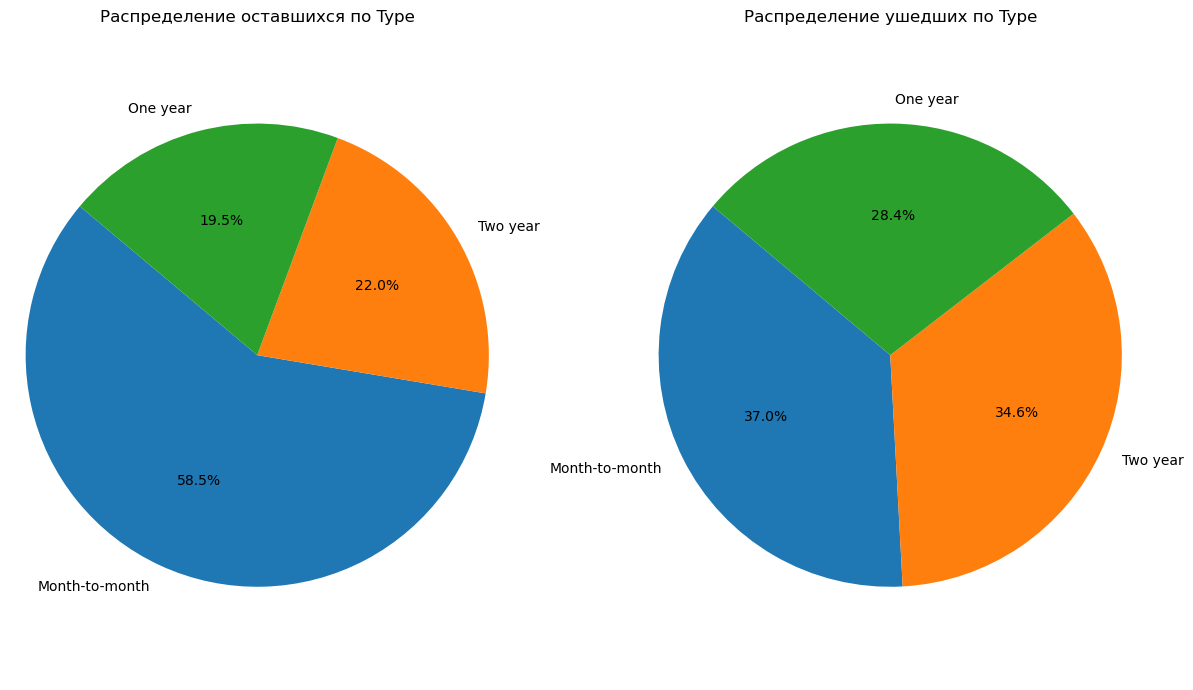

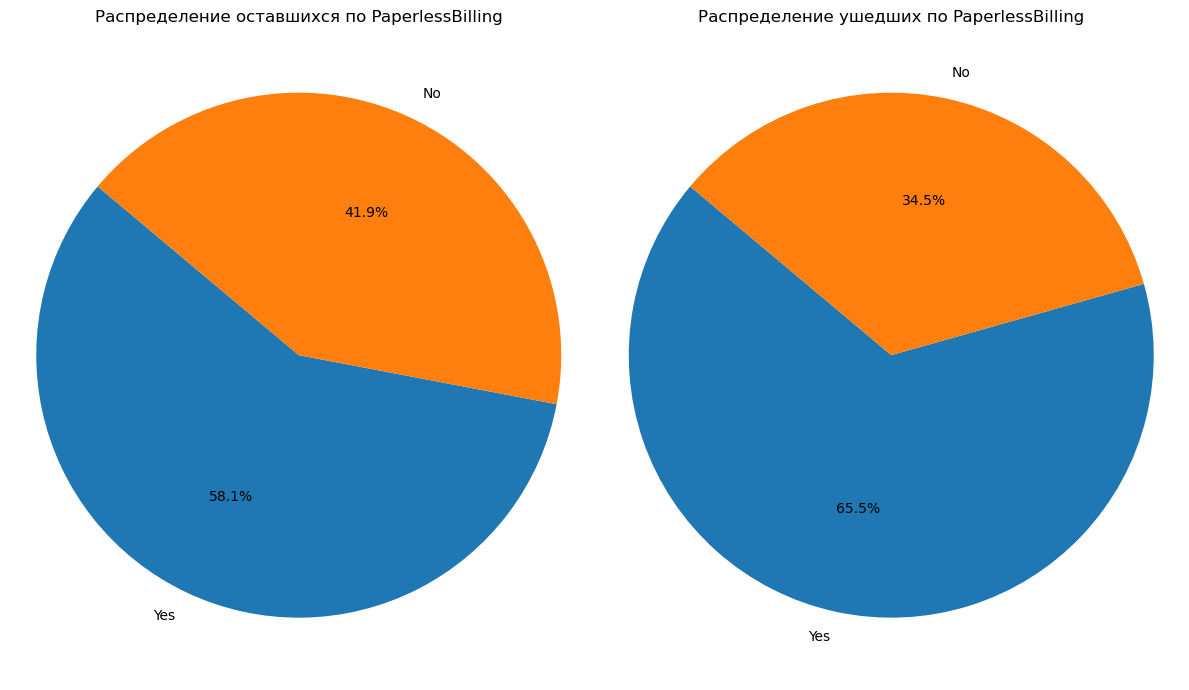

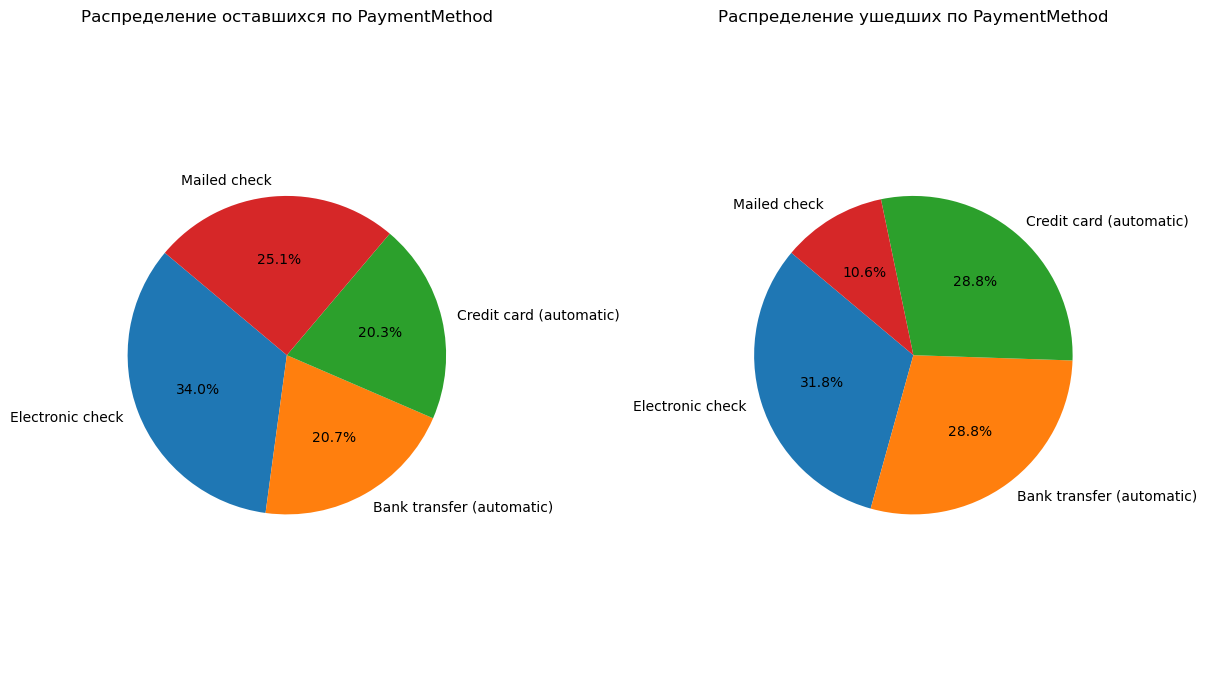

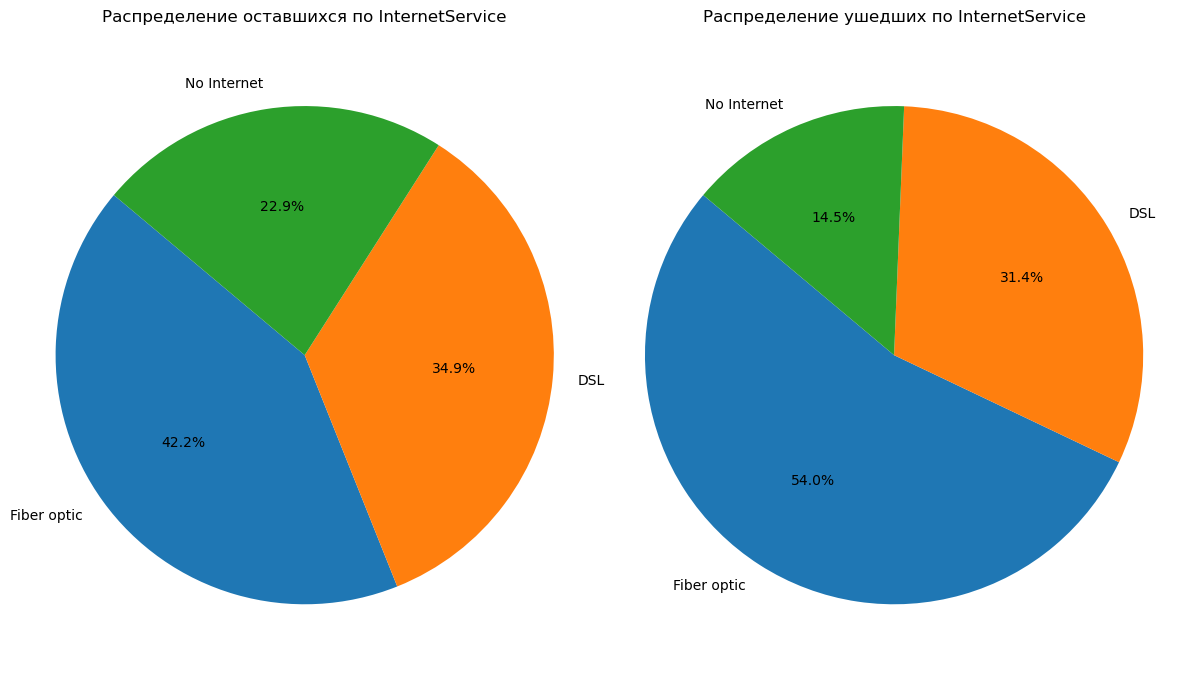

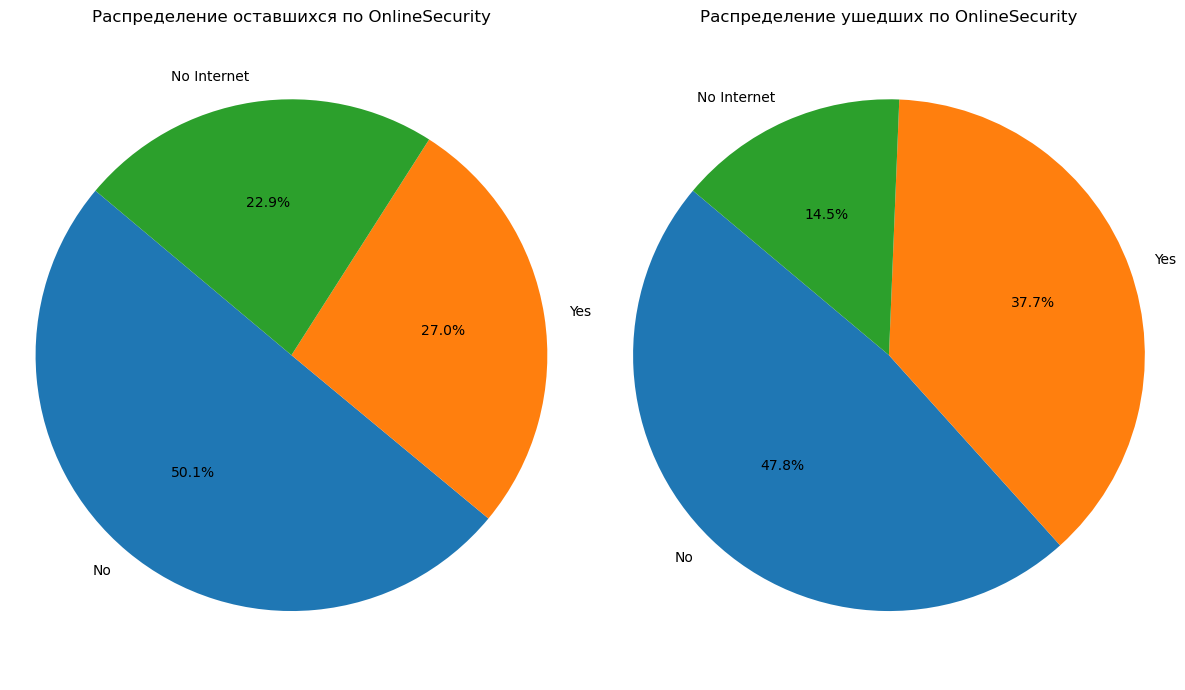

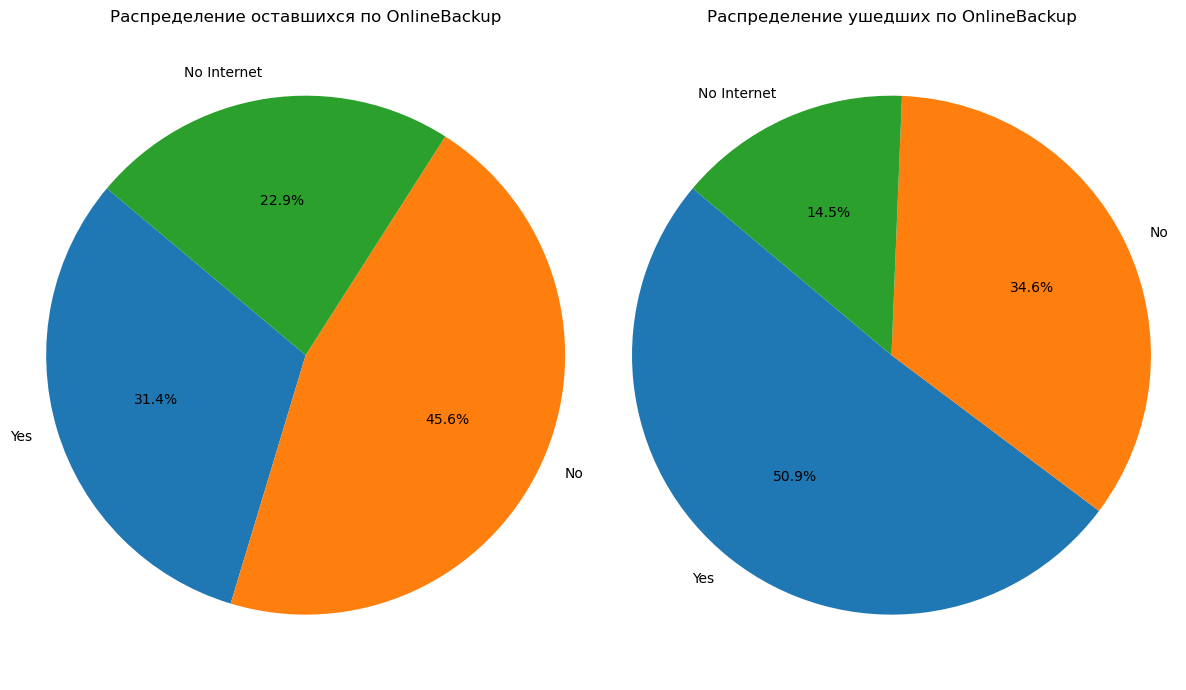

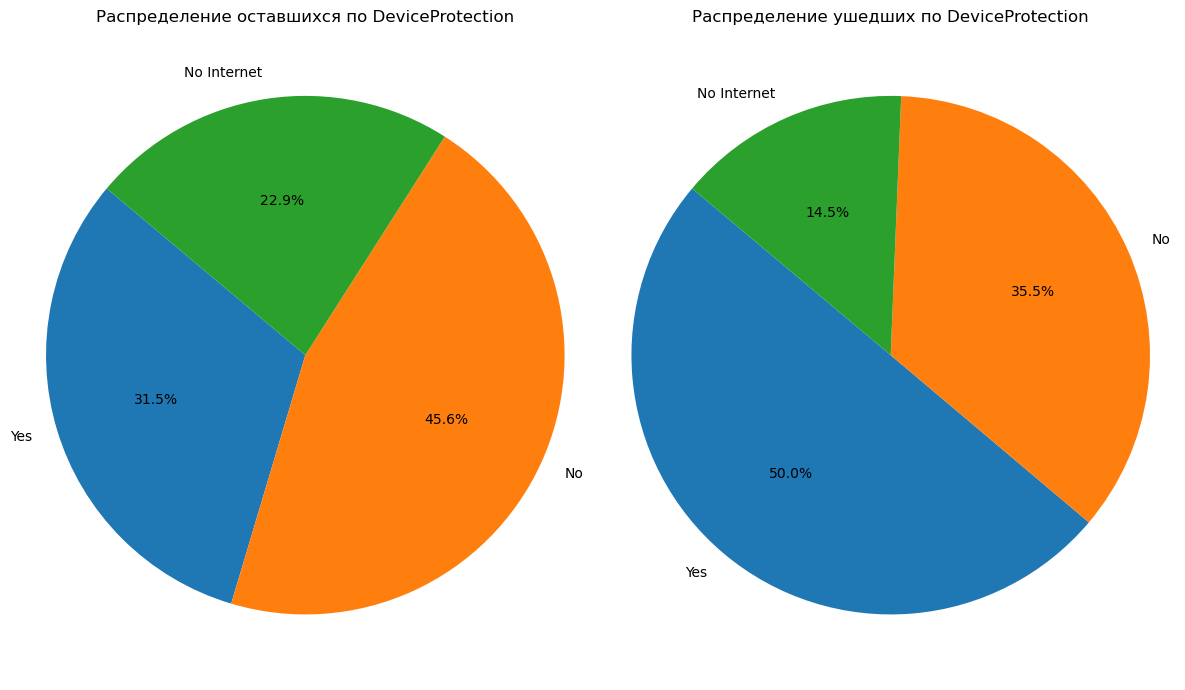

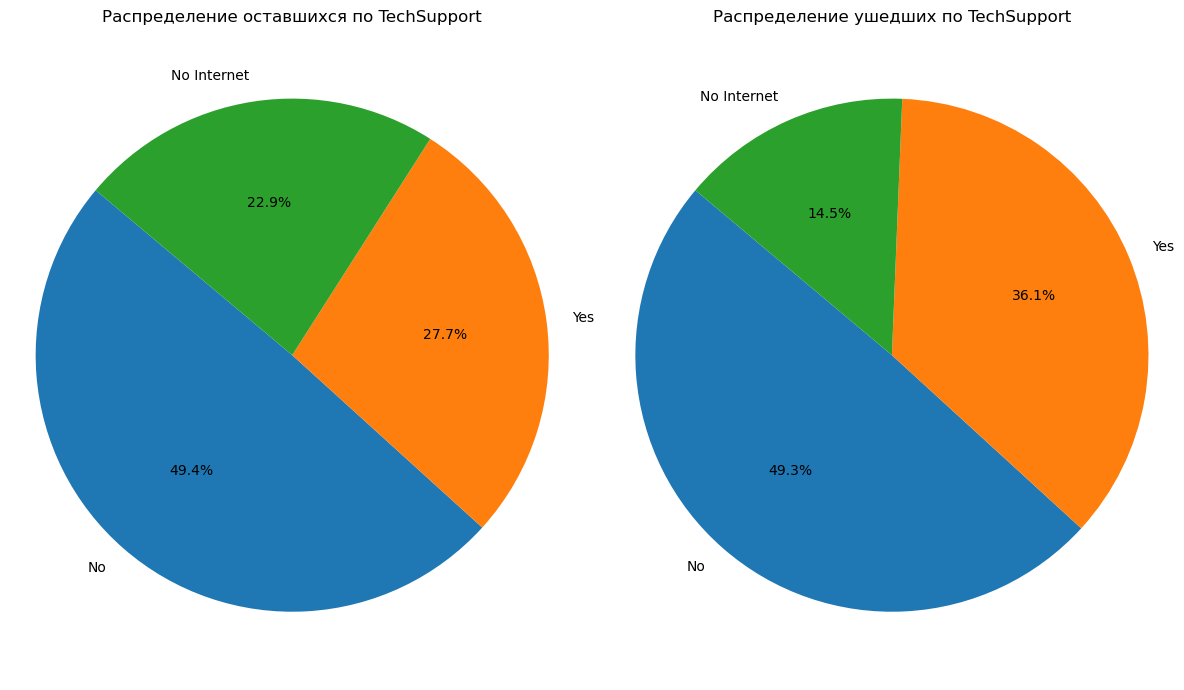

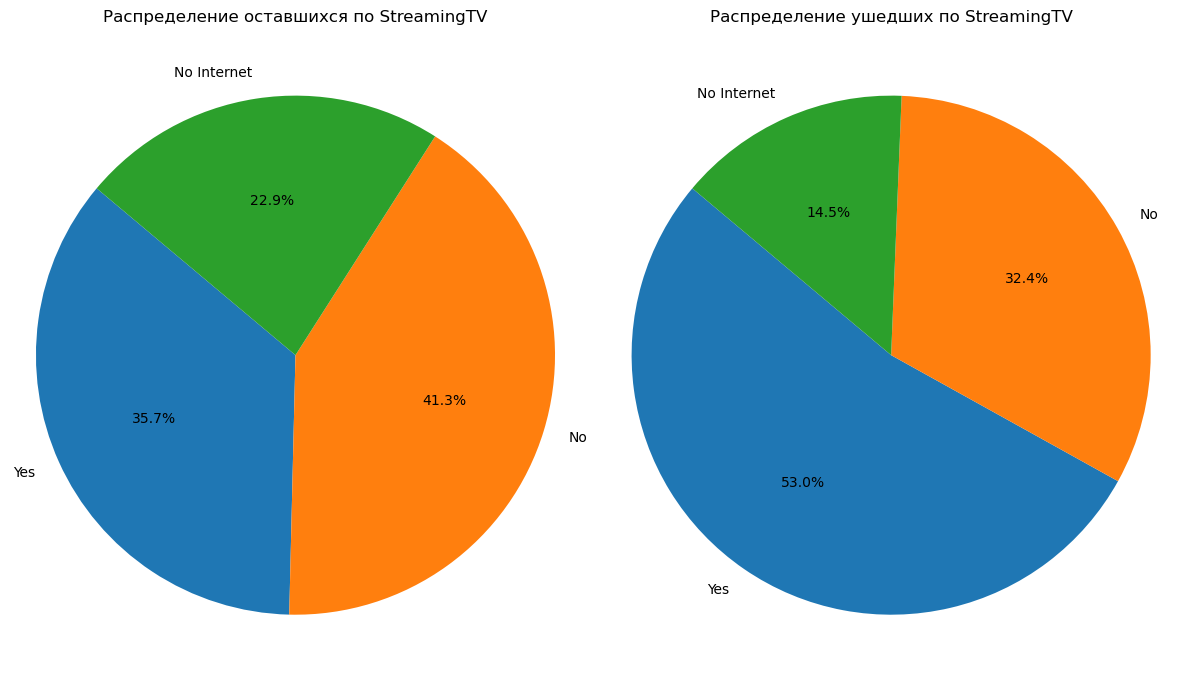

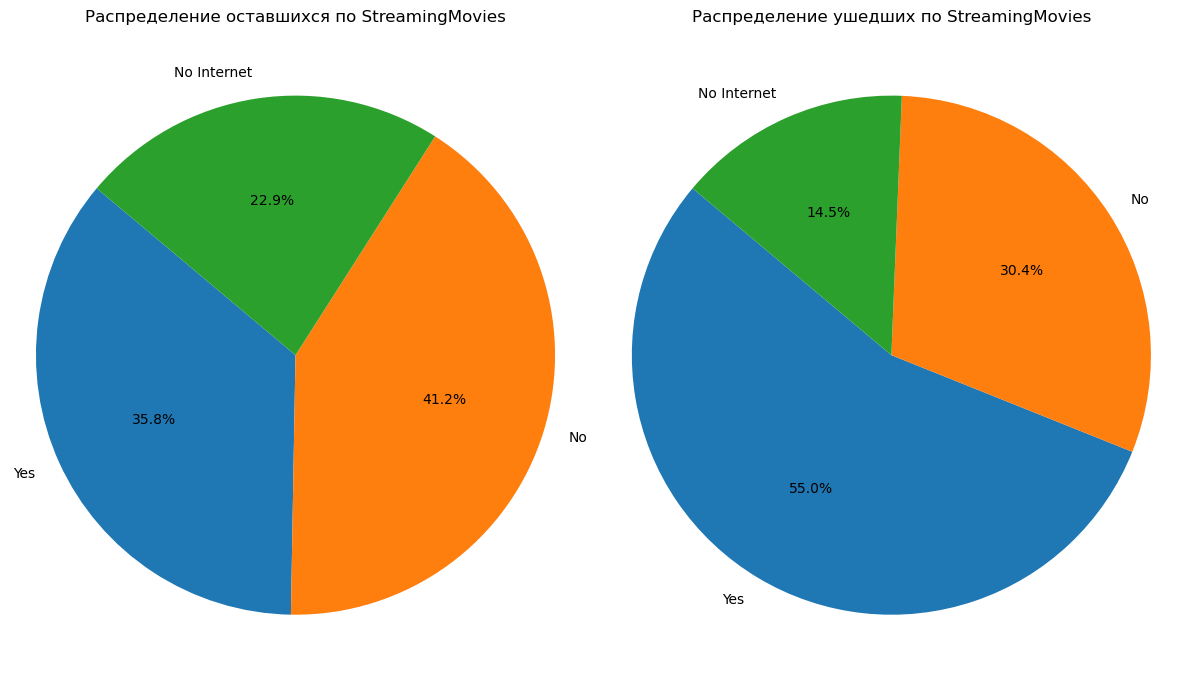

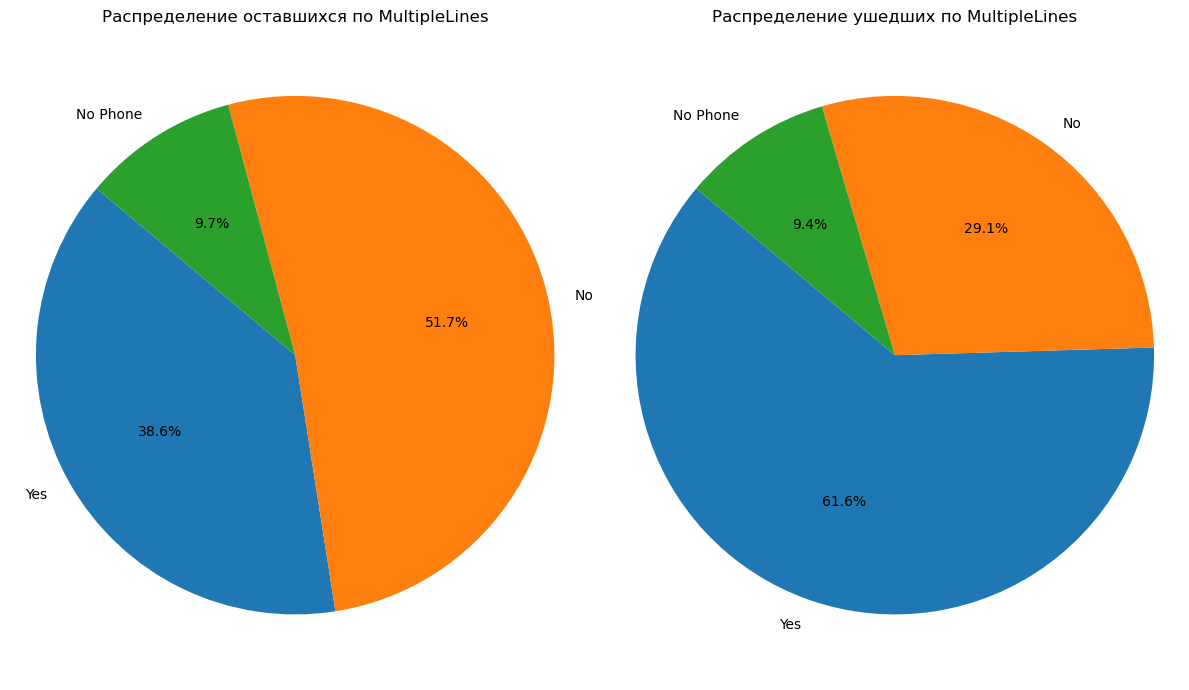

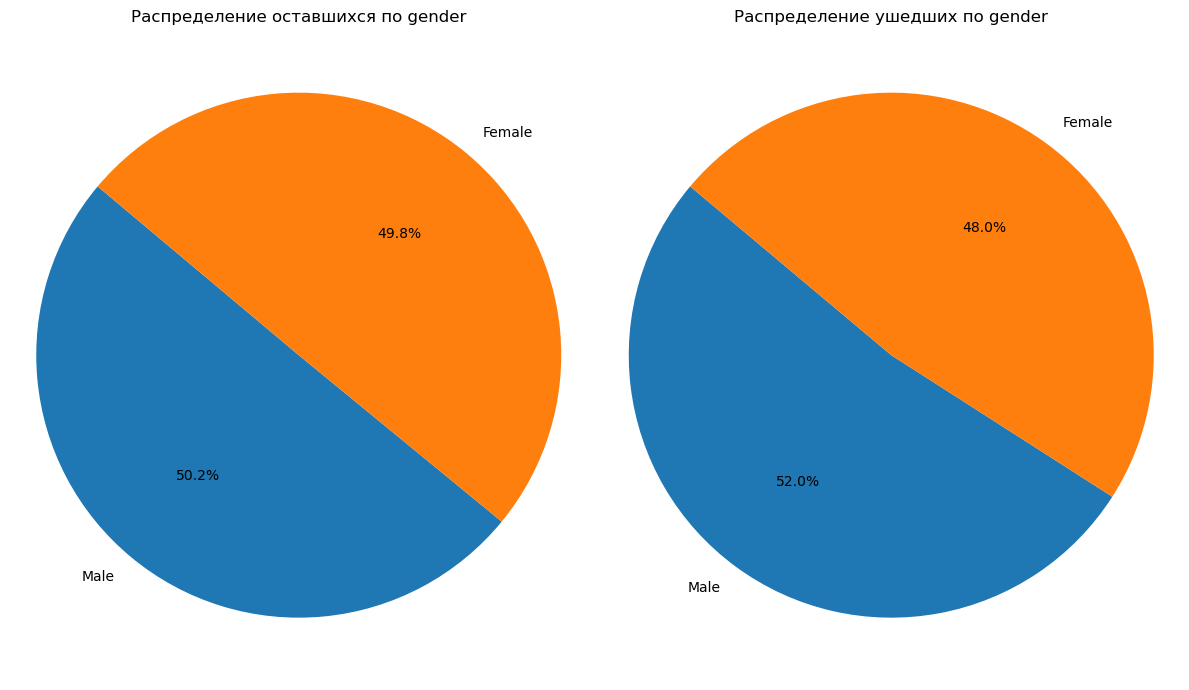

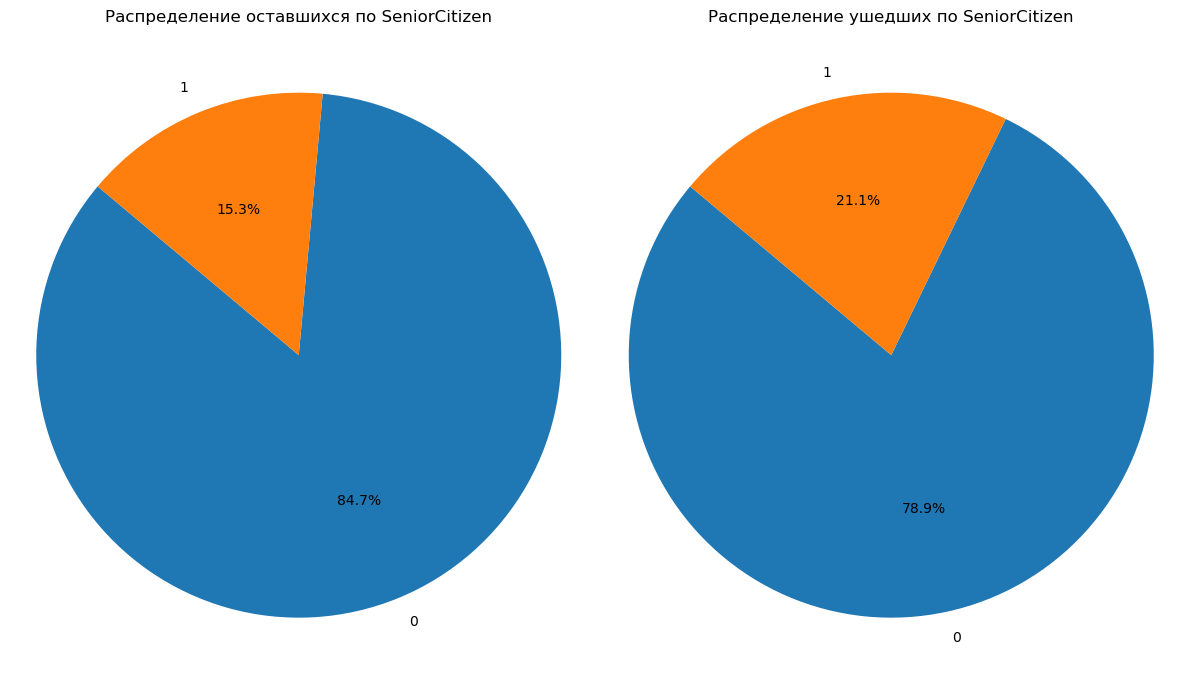

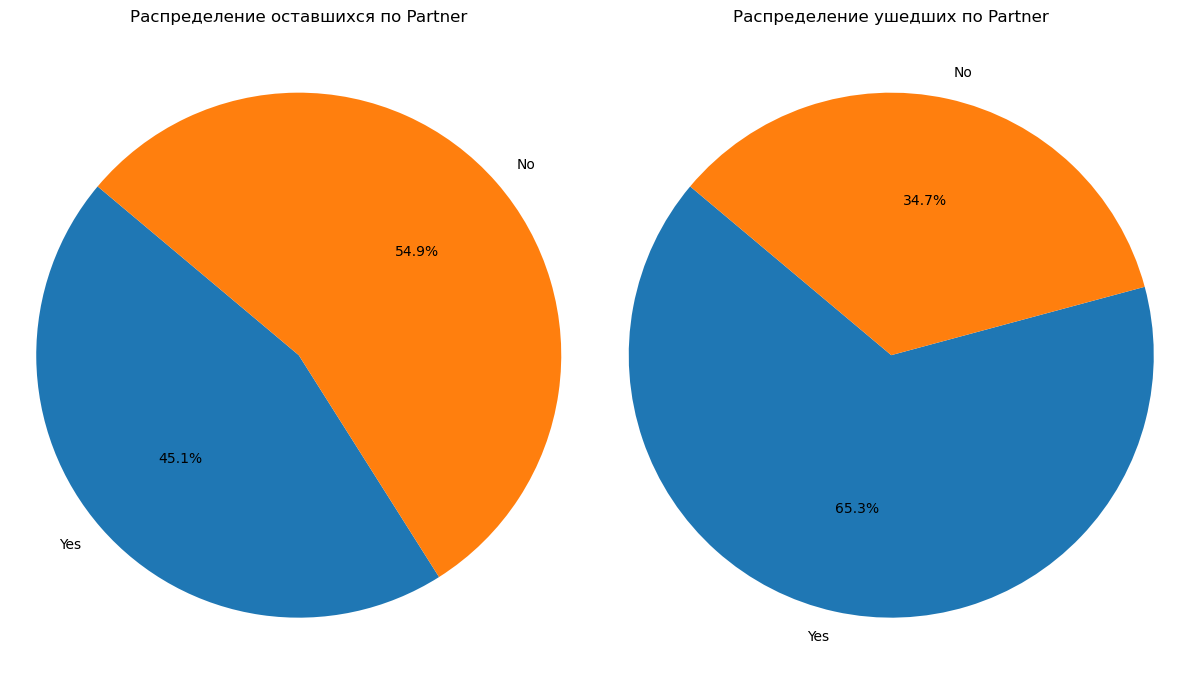

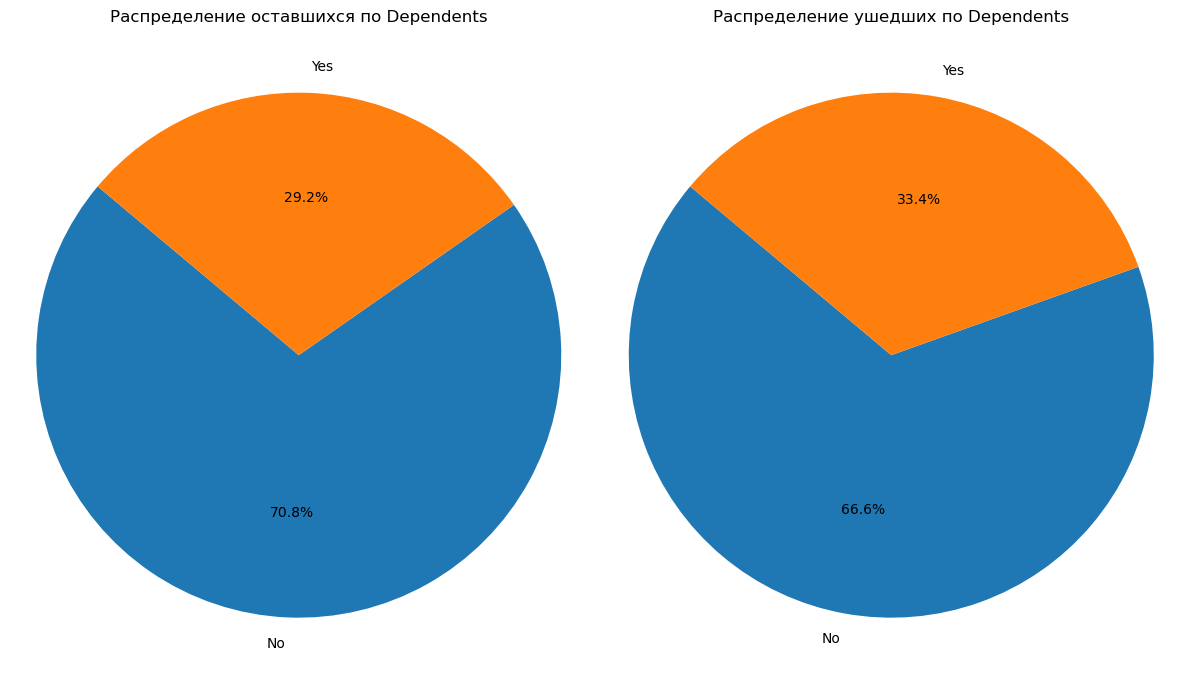

In [41]:
columns_to_plot = ['Type', 'PaperlessBilling',
       'PaymentMethod', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
       'MultipleLines', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents']

for i in columns_to_plot:
    values_left = left_users[i].value_counts()
    values_stayed = stayed_users[i].value_counts()
    values_stayed = values_stayed.reindex(values_left.index)

    plt.figure(figsize=(12, 7))

    plt.subplot(1, 2, 1)
    plt.pie(values_stayed, labels=values_stayed.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Распределение оставшихся по {i}')
    plt.axis('equal')
    
    plt.subplot(1, 2, 2)
    plt.pie(values_left, labels=values_left.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Распределение ушедших по {i}')
    plt.axis('equal')

    plt.tight_layout()
    plt.show()


По построенным графикам остались/ушли можно сделать следующие выводы:
1. В каждом виде оплаты ушло почти одинаковое количество пользователей, большая часть оставшихся платит ежемесячно, что может влиять на удержание;
2. Доля клиентов, которые получают электронный платежный документ, становится больше среди ушедших пользователей;
3. По типу оплаты видно, что проще всего удержать тех клиентов, которые оплачивают услуги по почте, сложнее - с автоматической оплатой услуг;
4. Визуализация видов интернета показывает, что ушедшим клиентам может не нравится качество оптоволоконного соединения, по сравнению с DSL;
5. Исходя из долей используемых сервисов компании можно подчеркнуть, что клиенты чаще уходят, если у них подключены какие-то из этих услуг, что может быть связано как с их качеством, так и с ценой;
6. Исходя из персональных данных клиентов можно сказать, что явные отличия видны только по признаку наличия супруга - среди ушедших клиентов на 20% растет доля тех, у кого он есть;
7. Доля людей, которые начали в 2014 и 2015 году и в итоге перестали пользоваться услугами выросла более чем в два раза, что может говорить о слабой поддержке старых пользователей. Также на это указывает то, что 33 процента из оставшихся пользователей начали в 2019, а таких же среди ушедших - 2.3. Возможно, компании стоит подумать над своей политикой по отношению к более старым клиентам;

Теперь посмотрим на количественные признаки

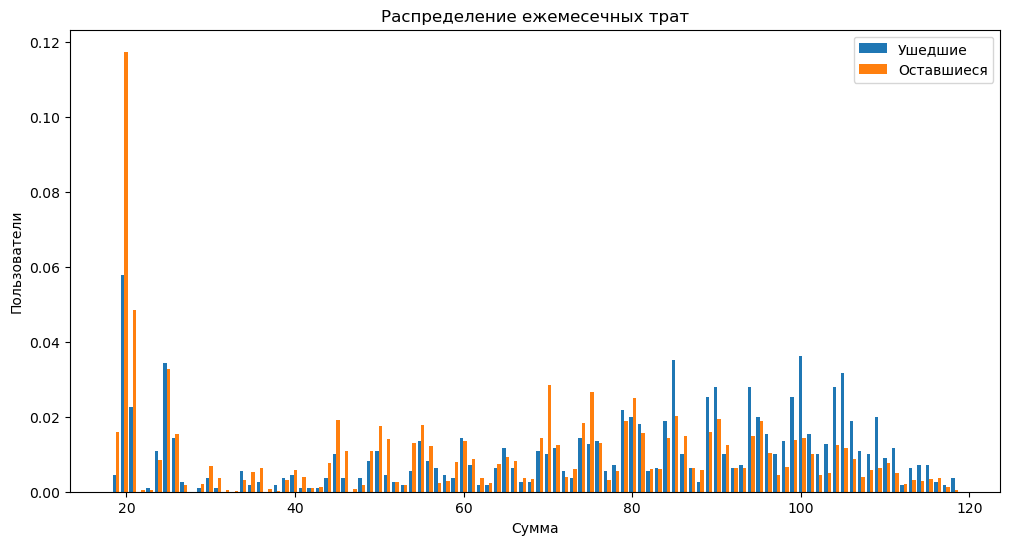

In [42]:
x = left_users.MonthlyCharges
y = stayed_users.MonthlyCharges
plt.figure(figsize=(12, 6))
plt.hist([x, y], 100, histtype ='bar', label=['Ушедшие', 'Оставшиеся'], density=True)
plt.title('Распределение ежемесечных трат')
plt.ylabel('Пользователи')
plt.xlabel('Сумма')
plt.legend()
plt.show()

По графику видно, что распределения ежемесячных трат во многом схожи, однако большее количество оставшихся пользователей имеют траты около 20 у.е. в месяц, а начиная с 80 у.е. ушедших становится больше

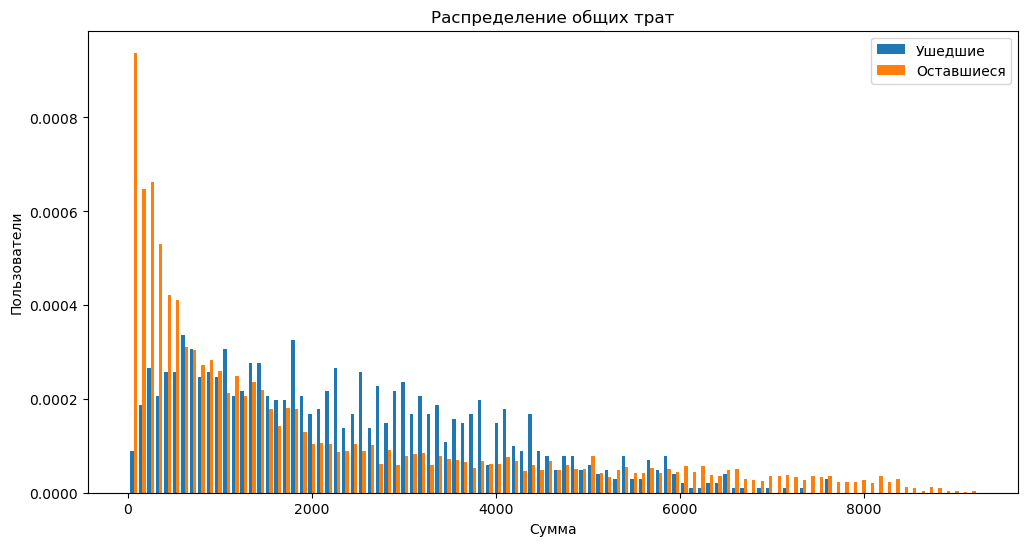

In [43]:
x = left_users.TotalCharges
y = stayed_users.TotalCharges
plt.figure(figsize=(12, 6))
plt.hist([x, y], 100, histtype ='bar', label=['Ушедшие', 'Оставшиеся'], density=True)
plt.title('Распределение общих трат')
plt.ylabel('Пользователи')
plt.xlabel('Сумма')
plt.legend()
plt.show()

У оставшихся пользователей распределение имеет плавное снижение, у ушедших - резкий спад после 4000 тысяч у.е, что может говорить об определенном 'опасном промежутке' в тратах пользователя, в который у него наибольшая вероятность прекратить использование услуг.

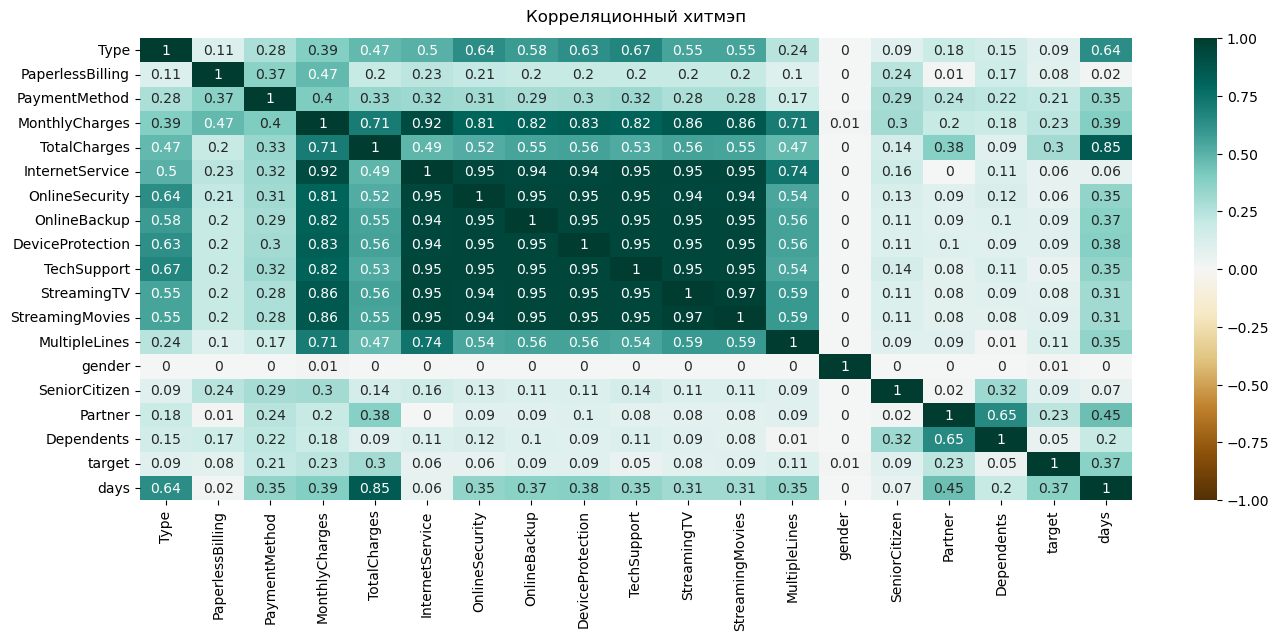

In [44]:
plt.figure(figsize=(16, 6))# тепловая карта корреляций
heatmap = sns.heatmap(df_all.drop(['customerID','BeginDate', 'EndDate'], axis=1).phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'days']).round(2), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Корреляционный хитмэп', fontdict={'fontsize':12}, pad=12);

  Признаки, которые показывают наличие дополнительных услуг и наличие интернета имеют очень высокую корреляцию между собой - придется их удалить и оставить только InternetService, чтобы избежать мультиколлинеарность. Также стоит удалить MonthlyCharges, так как признак имеет высокую корреляцию с общими тратами и интернет-услугами. Признак days также уберем - для обучения будет достаточно года начала использования услуг(begin_year)

Вместо нескольких признаков с доп. услугами создадим один, который будет показывать их количество у клиента.

In [45]:
# Создание признака "AdditionalServices"
additional_services_columns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
def count_additional_services(row):
    count = 0
    for col in additional_services_columns:
        if row[col] == 'Yes':
            count += 1
    return count

df_all['AdditionalServices'] = df_all.apply(count_additional_services, axis=1)

In [46]:
df_all[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'AdditionalServices']].head()

,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,AdditionalServices
0,No,Yes,No,No,No,No,1
1,Yes,No,Yes,No,No,No,2
2,Yes,Yes,No,No,No,No,2
3,Yes,No,Yes,Yes,No,No,3
4,No,No,No,No,No,No,0


### Проверка на дисбаланс классов, чувствительность метрики к дисбалансу классов

In [47]:
df_all.target.value_counts()

0    5931
1    1101
Name: target, dtype: int64

В целевом признаке наблюдается сильный дисбаланс, балансировку делать не будем, так как во время обучения модели не сильно зависят от баланса классов, а метрика ROC-AUC нечувствительна к нему, но важно сохранить соотношение в тренировочной и тестовой выборке. 

### Рзделение выборок, кодировка и масштабирование

Создадим датафреймы для таргета и признаков - отдельно для линейной модели и анализа и для бустинговых моделей

In [48]:
features_boost = df_all.drop(['customerID', 'BeginDate', 'EndDate', 'target', 
                              'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                              'StreamingTV', 'StreamingMovies', 'MonthlyCharges'], axis=1)
target_boost = df_all['target']

In [49]:
# делим обучающую и тестовую выборки
features_train_boost, features_test_boost, target_train, target_test = \
    train_test_split(features_boost, target_boost, test_size=0.25, random_state=RANDOM_STATE, stratify=target_boost)

In [50]:
print('Размеры тренировочных выборок:', features_train_boost.shape, target_train.shape)

Размеры тренировочных выборок: (5274, 12) (5274,)


In [51]:
print('Размеры тестовых выборок:', features_test_boost.shape, target_test.shape)

Размеры тестовых выборок: (1758, 12) (1758,)


In [52]:
features_train_boost.head()

,Type,PaperlessBilling,PaymentMethod,TotalCharges,InternetService,MultipleLines,gender,SeniorCitizen,Partner,Dependents,days,AdditionalServices
22,Month-to-month,No,Mailed check,61.05,No Internet,No,Male,0,No,No,92,0
1958,Month-to-month,Yes,Bank transfer (automatic),1781.85,Fiber optic,Yes,Male,0,No,No,638,2
1234,One year,Yes,Electronic check,5715.90,Fiber optic,No,Male,0,No,Yes,1645,5
4675,One year,Yes,Electronic check,3600.00,Fiber optic,Yes,Male,0,No,No,1095,3
2061,Month-to-month,No,Electronic check,487.00,DSL,No,Male,0,Yes,Yes,306,1


In [53]:
# масштабируем количественные признаки
scaler = StandardScaler()
columns_to_scale = ['TotalCharges', 'AdditionalServices', 'days']

scaled_columns_train = scaler.fit_transform(features_train_boost[columns_to_scale].values)
scaled_columns_test = scaler.transform(features_test_boost[columns_to_scale].values)

features_train_boost = features_train_boost.copy()
features_test_boost = features_test_boost.copy()

features_train_boost[columns_to_scale] = scaled_columns_train
features_test_boost[columns_to_scale] = scaled_columns_test

Создадим признаки для линейной модели с кодировкой

In [54]:
# ohe для остальных категорий
enc = OneHotEncoder(drop='first')
columns_to_ohe = ['Type', 'PaymentMethod', 'InternetService', 'MultipleLines', 
                  'PaperlessBilling', 'SeniorCitizen', 'Partner', 'Dependents', 'gender']
features_train_encoded = enc.fit_transform(features_train_boost[columns_to_ohe]).toarray()
features_test_encoded = enc.transform(features_test_boost[columns_to_ohe]).toarray()

# Создание нового датафрейма с закодированными признаками
encoded_features_train_df = pd.DataFrame(features_train_encoded, 
                                         columns=enc.get_feature_names_out(columns_to_ohe),
                                         index=features_train_boost.index)
encoded_features_test_df = pd.DataFrame(features_test_encoded, 
                                        columns=enc.get_feature_names_out(columns_to_ohe),
                                        index=features_test_boost.index)

# объединим признаки и результат кодирования и удалим ненужные столбцы
features_train_linear = features_train_boost.join(encoded_features_train_df).drop(columns=columns_to_ohe, axis=1)
features_test_linear = features_test_boost.join(encoded_features_test_df).drop(columns=columns_to_ohe, axis=1)

In [55]:
features_test_linear.head()

,TotalCharges,days,AdditionalServices,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No Internet,MultipleLines_No Phone,MultipleLines_Yes,PaperlessBilling_Yes,SeniorCitizen_1,Partner_Yes,Dependents_Yes,gender_Male
563,1.774727,1.312737,0.514296,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
3933,-0.914086,-0.908837,-1.104723,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
37,0.611487,0.733260,-0.565050,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1751,-0.240095,-0.510355,-0.025377,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3110,-0.988039,-1.266449,-1.104723,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Обучение и выбор модели

### Логистическая регрессия

In [56]:
%%time
log = LogisticRegression(random_state=RANDOM_STATE, max_iter=20000)
param_dist = { 'C': [0.001, 0.01, 0.1, 1, 10, 100],
          'class_weight': [None, 'balanced'],
          'solver': ['lbfgs', 'liblinear']
          }# распределение параметров для подбора
gsc = GridSearchCV(log, param_dist, cv=10, scoring='roc_auc', n_jobs=-1)# используем GridSearchCV для подбора параметров
search = gsc.fit(features_train_linear, target_train)
print(f'Лучшие параметры для линейной модели: {search.best_params_}')
print(f'Лучшее значение метрики ROC-AUC: {search.best_score_}')

Лучшие параметры для линейной модели: {'C': 0.1, 'class_weight': None, 'solver': 'lbfgs'}
Лучшее значение метрики ROC-AUC: 0.7653146182234363
CPU times: user 252 ms, sys: 105 ms, total: 358 ms
Wall time: 942 ms


In [57]:
model_log = LogisticRegression(C=search.best_params_['C'], class_weight=search.best_params_['class_weight'], solver=search.best_params_['solver'], random_state=RANDOM_STATE, max_iter=20000)# сохраним модель
model_log.fit(features_train_linear, target_train)

LogisticRegression(C=0.1, max_iter=20000, random_state=140823)

Модель показывает недостаточное значение метрики. Перейдем к более сложным.

###  CatBoost

In [58]:
%%time
cat_features = columns_to_ohe
param_grid =[{'max_depth': [3, 4, 5],
              'n_estimators':[100, 200, 300],
              'learning_rate': [0.01, 0.05, 0.1],
              'border_count': [128]}]

cat = CatBoostClassifier(random_state=RANDOM_STATE, cat_features=cat_features, verbose=100, eval_metric= 'AUC')
crscv = GridSearchCV(cat, param_grid, cv=10, scoring='roc_auc', n_jobs=-1, verbose=0)# Используем RandomizedSearchCV для перебора по сетке и подбора параметров
cat_search = crscv.fit(features_train_boost, target_train)

print("Лучшие параметры: ", cat_search.best_params_)
print("Лучшее значение метрики: ", cat_search.best_score_)

0:	total: 75.4ms	remaining: 7.46s
0:	total: 67.5ms	remaining: 6.68s
0:	total: 64.2ms	remaining: 6.36s
0:	total: 72.7ms	remaining: 7.2s
0:	total: 72.1ms	remaining: 7.14s
0:	total: 63.8ms	remaining: 6.32s
0:	total: 63ms	remaining: 6.24s
0:	total: 66.7ms	remaining: 6.6s
99:	total: 477ms	remaining: 0us
99:	total: 326ms	remaining: 0us
99:	total: 368ms	remaining: 0us
0:	total: 1.52ms	remaining: 150ms
0:	total: 4.4ms	remaining: 876ms
99:	total: 359ms	remaining: 0us
0:	total: 1.37ms	remaining: 136ms
99:	total: 468ms	remaining: 0us
99:	total: 436ms	remaining: 0us
0:	total: 5ms	remaining: 994ms
0:	total: 3.69ms	remaining: 734ms
99:	total: 352ms	remaining: 0us
0:	total: 3.58ms	remaining: 712ms
0:	total: 3.74ms	remaining: 745ms
99:	total: 468ms	remaining: 0us
99:	total: 303ms	remaining: 0us
0:	total: 6.86ms	remaining: 1.36s
0:	total: 8.84ms	remaining: 1.76s
99:	total: 498ms	remaining: 0us
0:	total: 3.59ms	remaining: 715ms
100:	total: 724ms	remaining: 710ms
100:	total: 672ms	remaining: 658ms
100:	t

Модель показывает очень хорошее значение метрики на кросс-валидации

In [59]:
model_cat = CatBoostClassifier(max_depth=cat_search.best_params_['max_depth'], n_estimators=cat_search.best_params_['n_estimators'], 
                               learning_rate=cat_search.best_params_['learning_rate'], border_count=cat_search.best_params_['border_count'], 
                               random_state=RANDOM_STATE, cat_features=cat_features, verbose=100, eval_metric= 'AUC')# сохраним модель
model_cat.fit(features_train_boost, target_train)

0:	total: 4.29ms	remaining: 1.28s
100:	total: 267ms	remaining: 525ms
200:	total: 556ms	remaining: 274ms
299:	total: 872ms	remaining: 0us


Судя по метрике, модель почти не ошибается в разметке класса 

### LightGBM

 Подготовим признаки

In [60]:
features_train_gbm, features_test_gbm = features_train_boost.copy(), features_test_boost.copy()
features_train_gbm[cat_features] = features_train_gbm[cat_features].astype('category')
features_test_gbm[cat_features] = features_test_gbm[cat_features].astype('category')

In [61]:
%%time
param_gbm = {
    'n_estimators': [150, 300, 500, 700],
    'num_leaves': [60, 65, 70],
    'max_depth': [3, 6, 10],
    'num_threads':[1]
}# распределение параметров для подбора

train_data = lgb.Dataset(data=features_train_gbm, label=target_train, categorical_feature=cat_features) #хранилище для признаков
test_data = lgb.Dataset(data=features_test_gbm, label=target_test, categorical_feature=cat_features)

gbm = lgb.LGBMClassifier(random_state=RANDOM_STATE)
grscv = GridSearchCV(gbm, param_gbm, cv=10, scoring='roc_auc', n_jobs=-1, verbose=0)
gbm_search = grscv.fit(train_data.data, train_data.label)# используем перекодированные признаки для подбора параметров

print("Лучшие параметры:", gbm_search.best_params_)
print("Лучшее значение метрики: ", gbm_search.best_score_)

[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM]

Метрика немного выросла по сравнению с CatBoost

In [62]:
model_gbm = lgb.LGBMClassifier(num_leaves=gbm_search.best_params_['num_leaves'],
                               n_estimators=gbm_search.best_params_['n_estimators'],
                               max_depth=gbm_search.best_params_['max_depth'], random_state=RANDOM_STATE)# сохраним модель
model_gbm.fit(train_data.data, train_data.label)

LGBMClassifier(max_depth=3, n_estimators=700, num_leaves=60,
               rendom_state=140823)

Проведем тестирование LightGBM

## Тестирование лучшей модели

In [63]:
predictions_test = model_gbm.predict_proba(test_data.data)
print(f'Оценка AUC-ROC на тестовой выборке: {roc_auc_score(target_test, predictions_test[:, 1])}')

Оценка AUC-ROC на тестовой выборке: 0.9276760865567338


Качество модели подтвердилось на тестовой выборке

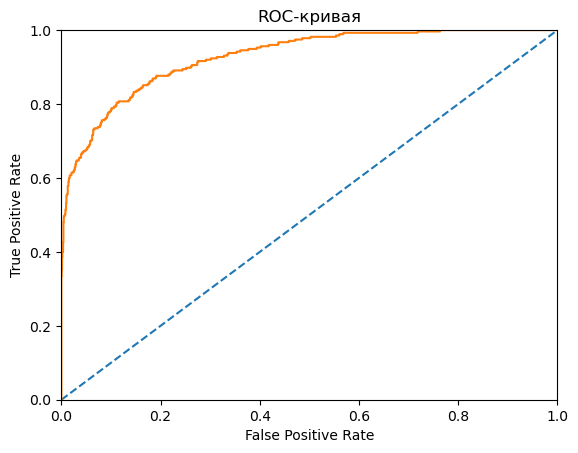

In [64]:
fpr, tpr, thresholds = roc_curve(target_test, predictions_test[:, 1])# вычисляем TPR и FPR
plt.figure()# строим график
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [65]:
dummy = DummyClassifier()
dummy.fit(features_train_linear, target_train)
predictions_dummy = dummy.predict_proba(features_test_linear)
print(f'Оценка AUC-ROC константной модели на тестовой выборке: {roc_auc_score(target_test, predictions_dummy[:, 1])}')

Оценка AUC-ROC константной модели на тестовой выборке: 0.5


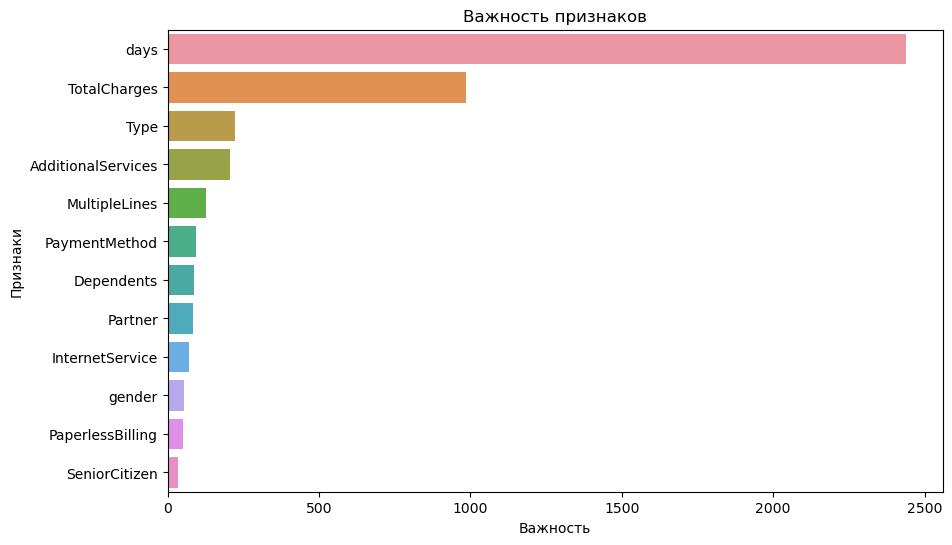

In [66]:
# Анализ важности признаков
feature_importances = model_gbm.feature_importances_
sorted_indices = feature_importances.argsort()[::-1]
sorted_features = [features_boost.columns[i] for i in sorted_indices]

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances[sorted_indices], y=sorted_features)
plt.title("Важность признаков")
plt.xlabel("Важность")
plt.ylabel("Признаки")
plt.show()

По графику видно, что наиболее важным признаком для предсказания является количество дней - он превышает следующий по важности более чем в два раза. Общие траты также сильно влияют на предсказания модели.

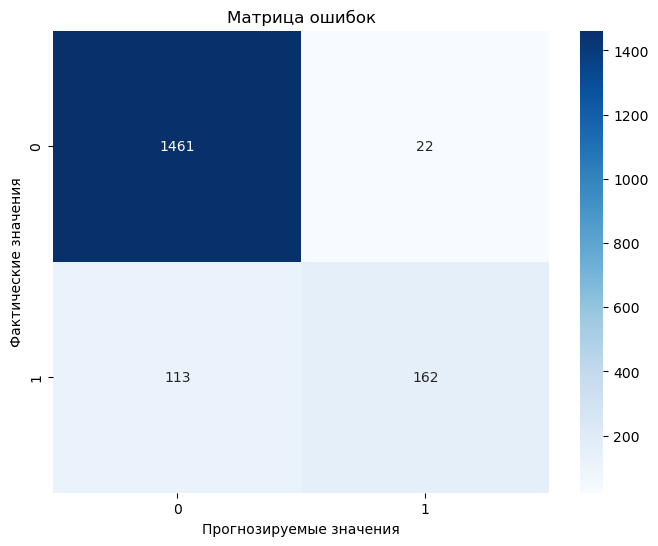

Отчет о классификации:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1483
           1       0.88      0.59      0.71       275

    accuracy                           0.92      1758
   macro avg       0.90      0.79      0.83      1758
weighted avg       0.92      0.92      0.92      1758


In [67]:
# Создание матрицы ошибок
conf_matrix = confusion_matrix(target_test, model_gbm.predict(test_data.data))

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Матрица ошибок")
plt.xlabel("Прогнозируемые значения")
plt.ylabel("Фактические значения")
plt.show()

# Вывод отчета о классификации
report = classification_report(target_test, model_gbm.predict(test_data.data))
print("Отчет о классификации:")
print(report)

Модель получила хороший результат по всем метрикам и способна с высокой точностью классифицировать возможный отказ клиента от услуг компании.

## Отчет по проделанной работе

1. Какие пункты плана были выполнены, а какие — нет. Почему?<br>
Все пункты плана и задача были успешно выполнены<br><br>
2. Какие трудности возникли и как вы их преодолели?<br>
Возникла сложность с выбором признаков, которые необходимо удалить, так как на первый взгляд под удаление попадало слишком много, что могло сказать на качестве модели. Однако кросс-валидация показала, что выбранных в итоге признаков было достаточно.<br><br>
3. Какие ключевые шаги в решении задачи вы выделили?<br>
Объединить данные и не потерять строки; заполнить пропуски, не понижая будущее качество модели; провести отбор признаков по корреляционному хитмепу, провести кодировку и масштабирование; проверить разные модели на кросс-валидации, выбрать лучшую и протестировать ее на отдельной выборке.<br><br>
4. Какие признаки использовали для обучения модели и какая предобработка этих признаков была выполнена?<br>
Для обучения модели использовались следующие признаки - количество дней с начала использования услуг компании, общие траты клиента на услуги, тип используемой подписки, кол-во дополнительных сервисов, которыми пользуется клиент, возможность использования параллельных телефонных линий, а также способ оплаты, кол-во иждевенцев, наличие партнера, наличие пенсионного статуса, пол, способ получения чека и используемый вид интернета. Категориальные признаки были закодированы с помощью техники OHE, количественные - масштабированы с помощью StandartScaler. Признак с количеством дней появился на основании разницы даты начала и конца использования услуг компании, а признак с кол-вом доп. услуг - сумма по полям с их списком.<br><br>
5. Какая ваша итоговая модель, какие у неё гиперпараметы и какое качество?<br>
Итоговая модель - LGBMClassifier(max_depth=3, n_estimators=700, num_leaves=60, random_state=140823). AUC-ROC на кросс-валидации - 0.914, на тесте - 0.927. Также модель показывает высокие результаты разметки не ушедших клиентов с precision - 0.93, recall - 0.99, f1-score - 0.96.<br><br>